In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "pekakkustudent"
os.environ['KAGGLE_KEY'] = "KGAT_53bba8bbf6b3602125ad69f7880a98e9"


Drive mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


TensorFlow streaming pipeline (fast I/O)

In [ ]:
import tensorflow as tf
import os
import numpy as np

DATASET_PATH = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD"

train_path = DATASET_PATH + "/train"
val_path   = DATASET_PATH + "/val"
test_path  = DATASET_PATH + "/test"

train_files = tf.data.Dataset.list_files(train_path + "/*/*.jpg", shuffle=True)
val_files   = tf.data.Dataset.list_files(val_path   + "/*/*.jpg", shuffle=False)
test_files  = tf.data.Dataset.list_files(test_path  + "/*/*.jpg", shuffle=False)


Label + image decode ops

In [ ]:
def get_label(file_path):
    parts = tf.strings.split(file_path, "/")
    class_name = parts[-2]
    return tf.where(class_name == "drowsy", 1, 0)

def decode_img(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224,224])
    img = tf.cast(img, tf.float32)
    return img

def process_path(file_path):
    label = get_label(file_path)
    img = decode_img(file_path)
    return img, label


Build datasets (prefetch + parallel)

In [ ]:
BATCH_SIZE = 64 #large batc

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

def build_dataset(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(4096)
    ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(AUTOTUNE)
    return ds

train_ds = build_dataset(train_files, shuffle=True)
val_ds   = build_dataset(val_files)
test_ds  = build_dataset(test_files)


In [ ]:
!nvidia-smi

Mon Nov 24 12:20:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P0             29W /   70W |     104MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Dataset size print

In [ ]:
train_count = len(list(train_files))
val_count   = len(list(val_files))
test_count  = len(list(test_files))

print("Train file count:", train_count)
print("Val file count:", val_count)
print("Test file count:", test_count)


Train file count: 46564
Val file count: 9978
Test file count: 9979


In [ ]:
print("Sample train files:")
for x in train_files.take(5):
    print(x.numpy())


Sample train files:
b'/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/notdrowsy/005_noglasses_yawning_1140_notdrowsy.jpg'
b'/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/notdrowsy/002_glasses_nonsleepyCombination_1054_notdrowsy.jpg'
b'/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/notdrowsy/005_noglasses_nonsleepyCombination_1457_notdrowsy.jpg'
b'/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/notdrowsy/006_glasses_slowBlinkWithNodding_1014_notdrowsy.jpg'
b'/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/drowsy/002_noglasses_yawning_1281_drowsy.jpg'


Build dataframe from dataset filenames

In [ ]:
import os
import pandas as pd
import re

DATASET_PATH = "/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD"

def parse_filename(path):
    filename = os.path.basename(path)

    # Example:
    # 001_glasses_sleepyCombination_1007_drowsy.jpg
    parts = filename.replace(".jpg","").split("_")

    # Safe defaults
    subject_id = parts[0]
    accessory = parts[1] if len(parts) > 1 else None
    scenario = parts[2] if len(parts) > 2 else None
    frame_idx = parts[3] if len(parts) > 3 else None
    condition = parts[4] if len(parts) > 4 else None

    return subject_id, accessory, scenario, frame_idx, condition


def build_dataframe(split):
    rows = []

    split_dir = os.path.join(DATASET_PATH, split)

    drowsy_dir = os.path.join(split_dir, "drowsy")
    notdrowsy_dir = os.path.join(split_dir, "notdrowsy")

    # Drowsy class
    for root,_,files in os.walk(drowsy_dir):
        for f in files:
            if f.endswith(".jpg"):
                fp = os.path.join(root, f)
                meta = parse_filename(fp)
                rows.append([*meta, fp, 1])

    # Not drowsy class
    for root,_,files in os.walk(notdrowsy_dir):
        for f in files:
            if f.endswith(".jpg"):
                fp = os.path.join(root, f)
                meta = parse_filename(fp)
                rows.append([*meta, fp, 0])

    df = pd.DataFrame(rows, columns=[
        "subject_id", "accessory", "scenario", "frame_idx", "condition_text",
        "filepath", "label"
    ])

    return df


print("Building train dataframe...")
df_train = build_dataframe("train")

print("Building val dataframe...")
df_val = build_dataframe("val")

print("Building test dataframe...")
df_test = build_dataframe("test")

df = pd.concat([df_train, df_val, df_test], ignore_index=True)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

df.head()


Building train dataframe...
Building val dataframe...
Building test dataframe...


,subject_id,accessory,scenario,frame_idx,condition_text,filepath,label
0,002,noglasses,slowBlinkWithNodding,584,notdrowsy,/content/drive/MyDrive/CMPE 593/datasets/proce...,0
1,005,glasses,nonsleepyCombination,1950,notdrowsy,/content/drive/MyDrive/CMPE 593/datasets/proce...,0
2,005,noglasses,nonsleepyCombination,1626,notdrowsy,/content/drive/MyDrive/CMPE 593/datasets/proce...,0
3,005,glasses,sleepyCombination,180,notdrowsy,/content/drive/MyDrive/CMPE 593/datasets/proce...,0
4,002,noglasses,slowBlinkWithNodding,764,drowsy,/content/drive/MyDrive/CMPE 593/datasets/proce...,1


Show image from df with label

Selected file: /content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/train/drowsy/005_noglasses_sleepyCombination_332_drowsy.jpg


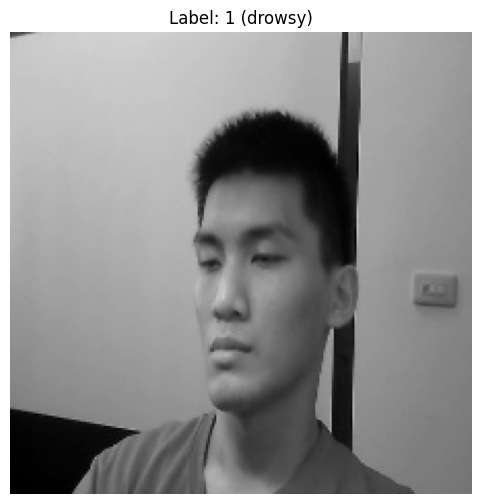

In [ ]:
import cv2
import matplotlib.pyplot as plt

row = df.sample(1).iloc[0]
fp = row["filepath"]
print("Selected file:", fp)

label = row["label"]

img = cv2.imread(fp)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(6,6))
plt.imshow(img)
plt.title(f"Label: {label} ({'drowsy' if label==1 else 'notdrowsy'})")
plt.axis("off")
plt.show()


# RESNET50V2 MODEL (transfer learning)

In [ ]:
from tensorflow.keras import layers, models
import tensorflow as tf

base_model = tf.keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

base_model.trainable = False

inputs = tf.keras.Input(shape=(224,224,3))
x = tf.keras.layers.Rescaling(1./255)(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid", dtype='float32')(x)


model = tf.keras.Model(inputs, outputs)




94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,566,849 (89.90 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

Training + Timer + EarlyStopping + Checkpoint

In [ ]:
import time

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(
        filepath="/content/resnet50v2_best.h5",
        save_best_only=True
    )
]

start_time = time.time()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)

end_time = time.time()
print("Training time (minutes):", (end_time - start_time) / 60)


Epoch 1/5
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.6106 - loss: 0.6547 

728/728 ━━━━━━━━━━━━━━━━━━━━ 30611s 42s/step - accuracy: 0.6107 - loss: 0.6546 - val_accuracy: 0.8113 - val_loss: 0.5104
Epoch 2/5
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.7831 - loss: 0.5024

728/728 ━━━━━━━━━━━━━━━━━━━━ 137s 187ms/step - accuracy: 0.7831 - loss: 0.5024 - val_accuracy: 0.8476 - val_loss: 0.4328
Epoch 3/5
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8246 - loss: 0.4385

728/728 ━━━━━━━━━━━━━━━━━━━━ 136s 187ms/step - accuracy: 0.8246 - loss: 0.4385 - val_accuracy: 0.8633 - val_loss: 0.3886
Epoch 4/5
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.8464 - loss: 0.3957

728/728 ━━━━━━━━━━━━━━━━━━━━ 137s 187ms/step - accuracy: 0.8464 - loss: 0.3957 - val_accuracy: 0.8746 - val_loss: 0.3575
Epoch 5/5
728/728 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.8549 - loss: 0.3694

728/728 ━━━━━━━━━━━━━━━━━━━━ 137s 187ms/step - accuracy: 0.8549 - loss: 0.3694 - val_accuracy: 0.8776 - val_loss: 0.3356
Training time (minutes): 519.3803718805314


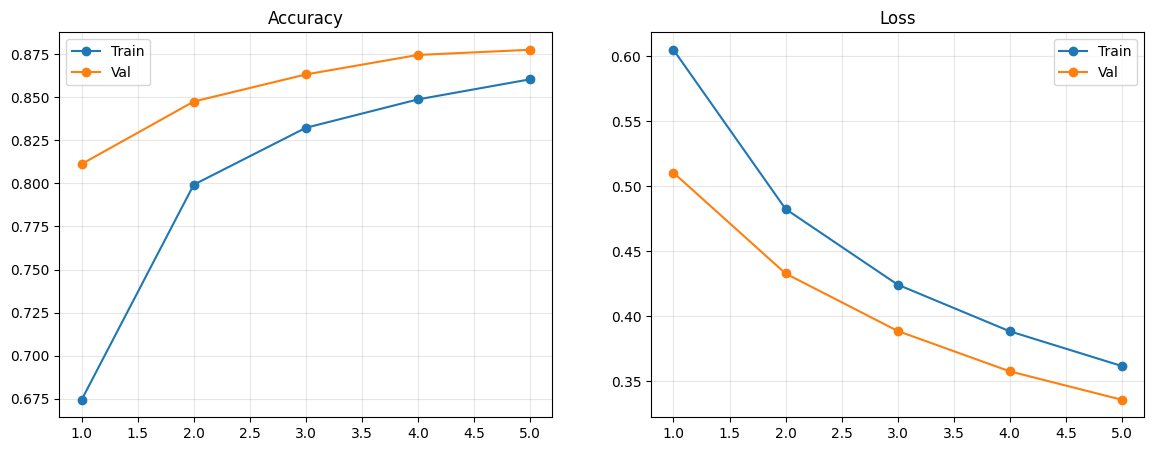

In [ ]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc, marker='o', label="Train")
plt.plot(epochs, val_acc, marker='o', label="Val")
plt.title("Accuracy")
plt.grid(True, alpha=.3)
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss, marker='o', label="Train")
plt.plot(epochs, val_loss, marker='o', label="Val")
plt.title("Loss")
plt.grid(True, alpha=.3)
plt.legend()

plt.show()


In [ ]:
model.save("/content/drive/MyDrive/CMPE 593/datasets/processed_datasets/NTHU-DDD/resnet50v2_final.keras")
print("Saved final ResNet50V2 model to Drive.")


Saved final ResNet50V2 model to Drive.


In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy:", test_acc)


156/156 ━━━━━━━━━━━━━━━━━━━━ 6419s 41s/step - accuracy: 0.9104 - loss: 0.3271
Test Accuracy: 0.8771420121192932


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Collect ground-truth and predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds = (preds > 0.5).astype("int32")

    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# ----- Classification Report -----
print("\nCLASSIFICATION REPORT:\n")
print(classification_report(y_true, y_pred, target_names=["notdrowsy", "drowsy"]))

# ----- Confusion Matrix -----
cm = confusion_matrix(y_true, y_pred)
print("\nCONFUSION MATRIX:\n")
print(cm)



CLASSIFICATION REPORT:

              precision    recall  f1-score   support

   notdrowsy       0.92      0.80      0.86      4574
      drowsy       0.85      0.94      0.89      5405

    accuracy                           0.88      9979
   macro avg       0.88      0.87      0.87      9979
weighted avg       0.88      0.88      0.88      9979


CONFUSION MATRIX:

[[3656  918]
 [ 308 5097]]


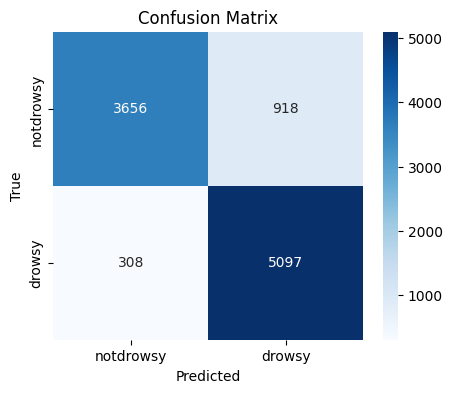

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=["notdrowsy", "drowsy"],
            yticklabels=["notdrowsy", "drowsy"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# FAST: Only computes probabilities (not thresholded predictions)
y_pred_probs = []

for images, _ in test_ds:   # ignore labels this time
    probs = model.predict(images, verbose=0).flatten()
    y_pred_probs.extend(probs)

y_pred_probs = np.array(y_pred_probs)


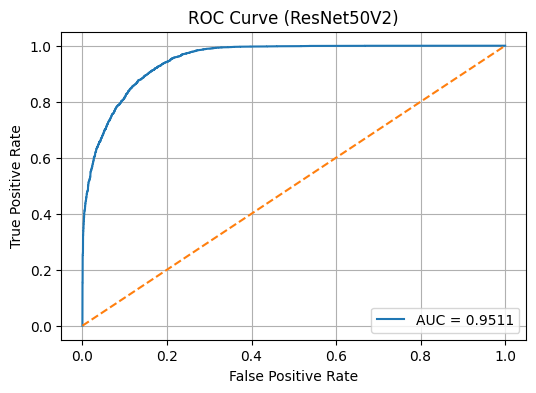

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(y_true, y_pred_probs)
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], '--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (ResNet50V2)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import time
import numpy as np

print("\n---------- INFERENCE TIMING (ResNet50V2) ----------\n")

# Take one batch from test set
sample_batch = next(iter(test_ds))
sample_img = sample_batch[0][0]     # first image in batch
sample_img = tf.expand_dims(sample_img, axis=0)

# Warm-up (avoids measuring TF graph build time)
_ = model.predict(sample_img, verbose=0)

# Measure inference time over multiple runs
start = time.time()
for _ in range(50):
    _ = model.predict(sample_img, verbose=0)
end = time.time()

avg_inf_ms = (end - start) / 50 * 1000
print(f"Average inference time per image: {avg_inf_ms:.2f} ms")



---------- INFERENCE TIMING (ResNet50V2) ----------

Average inference time per image: 70.92 ms
